<a href="https://colab.research.google.com/github/aamernabi/deep-learning-examples/blob/master/regression/Boston_Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Boston Housing Price

In this example we’ll attempt to predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on.

The dataset has only 506 data pointes, split between 404 training samples and 102 test samples.  And each feature in the input data (for example, the crime rate) has a different scale

In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [65]:
import tensorflow as tf
from tensorflow.keras.datasets import boston_housing

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

print("tensorflow version: {}".format(tf.__version__))

tensorflow version: 2.2.0


In [66]:
# load dataset
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [67]:
print(train_data.shape)
print(train_targets.shape)
print(test_data.shape)
print(test_targets.shape)

(404, 13)
(404,)
(102, 13)
(102,)


In [68]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [69]:
#The targets are the median values of owner-occupied homes, in thousands of dollars
train_targets[0]

15.2

As you can see, you have 404 training samples and 102 test samples, each with 13 numerical features, such as per capita crime rate, average number of rooms per dwelling, accessibility to highways, and so on. 

### Preparing the data 

In [70]:
def normalize(data):
  mean = data.mean(axis=0)
  data -= mean
  std = data.std(axis=0)
  data /= std
  return data


In [71]:
train_data = normalize(train_data)
test_data = normalize(test_data)


### Building your network 

In [72]:
def build_model():
  model = Sequential([
    Dense(64, activation='relu', input_shape=(train_data.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
  ])
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

####  K-fold validation 

In [73]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [74]:
print(all_scores)
print(np.mean(all_scores))

[2.191196918487549, 2.745497703552246, 2.7456600666046143, 2.3237030506134033]
2.501514434814453


#### 500 epochs

In [79]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [80]:
# compute the average of the per-epoch MAE scores for all folds
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

##### Plotting validation scores

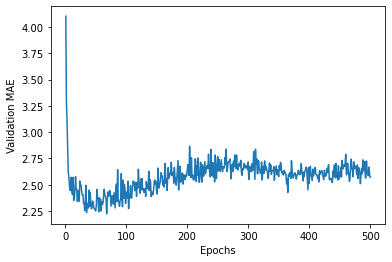

In [81]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#####  Plotting validation scores, excluding the first 10 data points

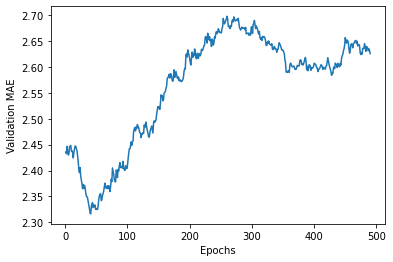

In [82]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Training the final model 

In [88]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


4/4 [==============================] - 0s 2ms/step - loss: 18.7291 - mae: 2.9207


In [89]:
print(test_mae_score)

2.9207208156585693


We’re still off by about $2,550.